In [71]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import datetime
import torch
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(224)

## Loading data

In [32]:
col = ['target','F1R','F1S','F2R','F2S','F3R','F3S','F4R','F4S','F5R','F5S','F6R','F6S','F7R','F7S','F8R','F8S','F9R','F9S','F10R','F10S',
      'F11R','F11S','F12R','F12S','F13R','F13S','F14R','F14S','F15R','F15S','F16R','F16S','F17R','F17S','F18R','F18S',
      'F19R','F19S','F20R','F20S','F21R','F21S','F22R','F22S']

train = pd.read_csv('data/SPECTF_train.csv', header=None, low_memory=False,names = col,)
train.head()
test = pd.read_csv('data/SPECTF_test.csv', header=None, low_memory=False,names = col)

scaler = StandardScaler()
y_train = train['target'].values.reshape(-1,1)
y = train['target'].values
X = train.drop('target',axis = 1).values
test_y = test['target'].values.reshape(-1,1)
test_x = test.drop('target',axis = 1).values
X_std = scaler.fit_transform(X)

/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Activation Function

In [15]:

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    z = Z[:]
    z[z<0] = 0
    return z

def sigmoid_backward(sig):
    return (sig * (1 - sig))

def relu_backward(Z):
    dZ = Z.copy()
    dZ[dZ > 0] = 1
    return dZ;

def step(Z):
    Z[Z>=0] = 1
    Z[Z<0] = 0
    return Z

def bina(Z):
    dZ = Z.copy()
    dZ[dZ > 0.5] = 1
    dZ[dZ <= 0.5] = 0
    return dZ
    
def tanh(Z):
    return (np.exp(2*Z) -1)/(np.exp(2*Z) +1)

def tanh_backward(tan):
    return (1 - tan**2)



In [16]:
## Modeling

In [17]:
def weight_initial(m,n): # xiviar initial
    weights= np.random.randn(m, n) / np.sqrt(m)
    bias = np.random.randn(1, n) / np.sqrt(m)
    return weights,bias
        
class MN(object):
    def __init__(self,n_feature, n_input,n_hidden, n_output,activation = 'sigmoid'): # 3 matrix
        np.random.seed(224)
        self.input_weights,self.input_bias = weight_initial(n_feature, n_input) #m x l1
        self.hidden_weights,self.hidden_bias = weight_initial(n_input,n_hidden) # l1 x l2
        self.output_weights,self.output_bias = weight_initial(n_hidden, n_output) # l2 x l3
        self.activation = activation
        
    def forward(self,inputx):
        if self.activation == 'sigmoid':
            self.out1 = sigmoid(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = sigmoid(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = sigmoid(np.dot(self.out2,self.output_weights) + self.output_bias)
            #print(self.out3)
        
        if self.activation == 'step':
            self.out1 = step(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = step(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = step(np.dot(self.out2,self.output_weights) + self.output_bias)
            
        if self.activation == 'tanh':
            self.out1 = tanh(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = tanh(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = tanh(np.dot(self.out2,self.output_weights) + self.output_bias)
            
        if self.activation == 'relu':
            self.out1 = relu(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = relu(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = relu(np.dot(self.out2,self.output_weights) + self.output_bias)
    
    def loss(self,X_train,y_train):
        self.forward(X_train)
        self.error3 = y_train - self.out3
        self.error2 = np.mean(self.error3 * self.output_weights.T,axis = 0).reshape(1,-1)
        self.error1 = self.error2.dot(self.hidden_weights.T)
        return np.mean(self.error3**2)
            
    def backward(self,inputx, y_train,learnrate):
        if self.activation == 'sigmoid':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(sigmoid_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * sigmoid_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(sigmoid_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (sigmoid_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(sigmoid_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * sigmoid_backward(self.out1),axis = 0)
            
            
        if self.activation == 'tanh':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(tanh_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * tanh_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(tanh_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (tanh_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(tanh_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * tanh_backward(self.out1),axis = 0)
            
        
        if self.activation == 'relu':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(relu_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * relu_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(relu_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (relu_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(relu_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * relu_backward(self.out1),axis = 0)
      
            
    def train(self,X_train,y_train,learnrate, iteration = 100):
        self.losses = []
        for i in range(iteration):
            self.loss(X_train,y_train)
            self.backward(X_train,y_train,learnrate)
            
            
            if i % 100 ==0:
                self.losses.append(self.loss(X_train,y_train))
                print('Epoch: ', str(i) +'| ' +str(iteration), '| train loss: %.4f' % self.losses[-1])
            
    def predict(self,X,y):
        self.forward(X)
        self.prob =self.out3
        self.pre = bina(self.prob)
        fpr,tpr,thresholds = roc_curve(y, self.pre)
        acc = list(y-self.pre).count(0)/len(self.pre)
        
        print('Acc: {}'.format(acc))
        print(classification_report(y,self.pre))
        print(confusion_matrix(y,self.pre))
        print("AUC: {}".format(roc_auc_score(y, self.pre)))
        sns.set_style()
        plt.figure(figsize=(8,6),dpi = 300)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
  

Epoch:  0| 3000 | train loss: 0.2803
Epoch:  100| 3000 | train loss: 0.2552
Epoch:  200| 3000 | train loss: 0.2529
Epoch:  300| 3000 | train loss: 0.2527
Epoch:  400| 3000 | train loss: 0.2527
Epoch:  500| 3000 | train loss: 0.2527
Epoch:  600| 3000 | train loss: 0.2527
Epoch:  700| 3000 | train loss: 0.2527
Epoch:  800| 3000 | train loss: 0.2527
Epoch:  900| 3000 | train loss: 0.2527
Epoch:  1000| 3000 | train loss: 0.2527
Epoch:  1100| 3000 | train loss: 0.2527
Epoch:  1200| 3000 | train loss: 0.2527
Epoch:  1300| 3000 | train loss: 0.2527
Epoch:  1400| 3000 | train loss: 0.2527
Epoch:  1500| 3000 | train loss: 0.2527
Epoch:  1600| 3000 | train loss: 0.2527
Epoch:  1700| 3000 | train loss: 0.2527
Epoch:  1800| 3000 | train loss: 0.2527
Epoch:  1900| 3000 | train loss: 0.2527
Epoch:  2000| 3000 | train loss: 0.2527
Epoch:  2100| 3000 | train loss: 0.2527
Epoch:  2200| 3000 | train loss: 0.2527
Epoch:  2300| 3000 | train loss: 0.2527
Epoch:  2400| 3000 | train loss: 0.2527
Epoch:  2500

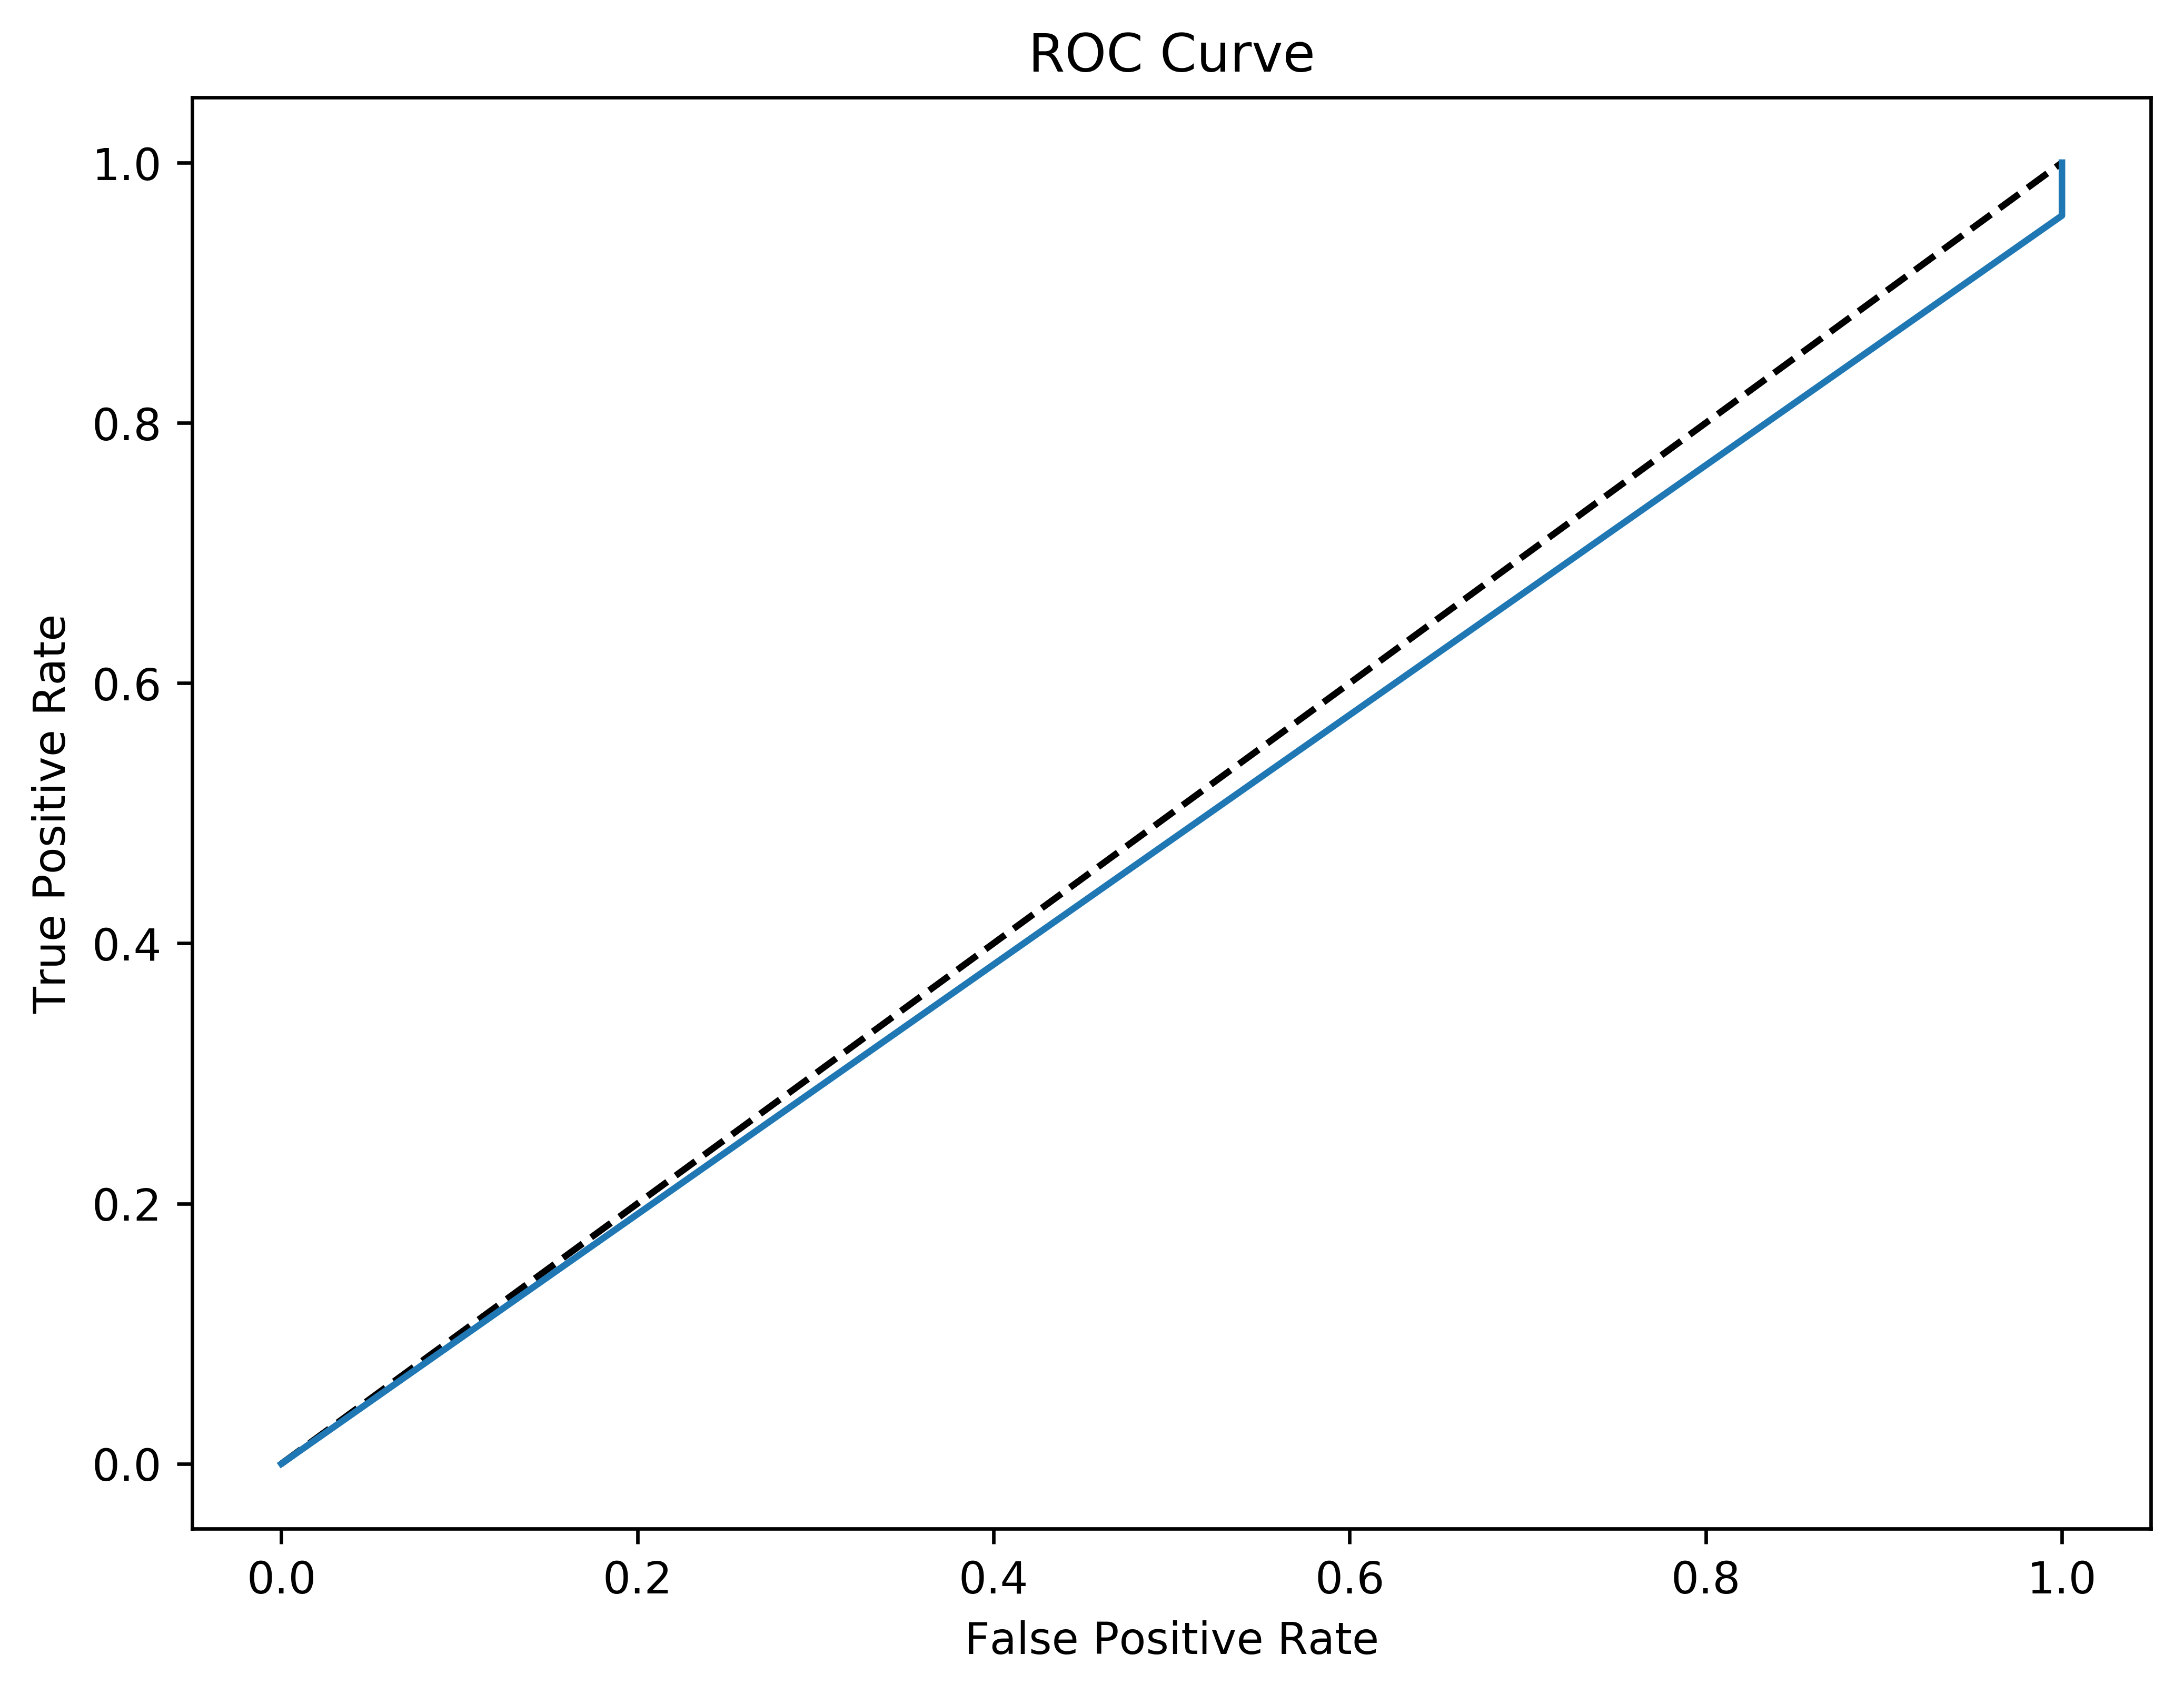

In [22]:
import datetime
starttime = datetime.datetime.now()
mm34 = MN(44,3,4,1,activation='sigmoid')
mm34.train(X_std,y_train,0.001,iteration = 3000)
endtime = datetime.datetime.now()
print('Runing time : ', (endtime - starttime))
mm34.predict(test_x,test_y)

In [24]:
def getNumbernode(nodeList= [30,30,1],act = 'sigmoid',lr = 0.001,iteration = 1500):
    loss_list = []
    for i in range(nodeList[0]):
        
        for j in range(nodeList[1]):
            mm = MN(44,i+1,j+1,1,activation = act)
            mm.train(X_std,y_train,lr,iteration)
            loss_list.append([i+1,j+1,mm.losses[-1]])
    
    mse = [x[2] for x in loss_list]
    minmse =  min(mse)
    _ = mse.index(minmse)
    print('first nodes : ',loss_list[_][0],'  second nodes : ',loss_list[_][1])
    return loss_list[_]  

In [ ]:
test = getNumbernode()
# 22,5,1

Epoch:  0| 3000 | train loss: 0.2370
Epoch:  100| 3000 | train loss: 0.2337
Epoch:  200| 3000 | train loss: 0.2338
Epoch:  300| 3000 | train loss: 0.2338
Epoch:  400| 3000 | train loss: 0.2338
Epoch:  500| 3000 | train loss: 0.2338
Epoch:  600| 3000 | train loss: 0.2338
Epoch:  700| 3000 | train loss: 0.2338
Epoch:  800| 3000 | train loss: 0.2338
Epoch:  900| 3000 | train loss: 0.2338
Epoch:  1000| 3000 | train loss: 0.2338
Epoch:  1100| 3000 | train loss: 0.2338
Epoch:  1200| 3000 | train loss: 0.2338
Epoch:  1300| 3000 | train loss: 0.2338
Epoch:  1400| 3000 | train loss: 0.2338
Epoch:  1500| 3000 | train loss: 0.2338
Epoch:  1600| 3000 | train loss: 0.2338
Epoch:  1700| 3000 | train loss: 0.2338
Epoch:  1800| 3000 | train loss: 0.2338
Epoch:  1900| 3000 | train loss: 0.2338
Epoch:  2000| 3000 | train loss: 0.2338
Epoch:  2100| 3000 | train loss: 0.2338
Epoch:  2200| 3000 | train loss: 0.2338
Epoch:  2300| 3000 | train loss: 0.2338
Epoch:  2400| 3000 | train loss: 0.2338
Epoch:  2500

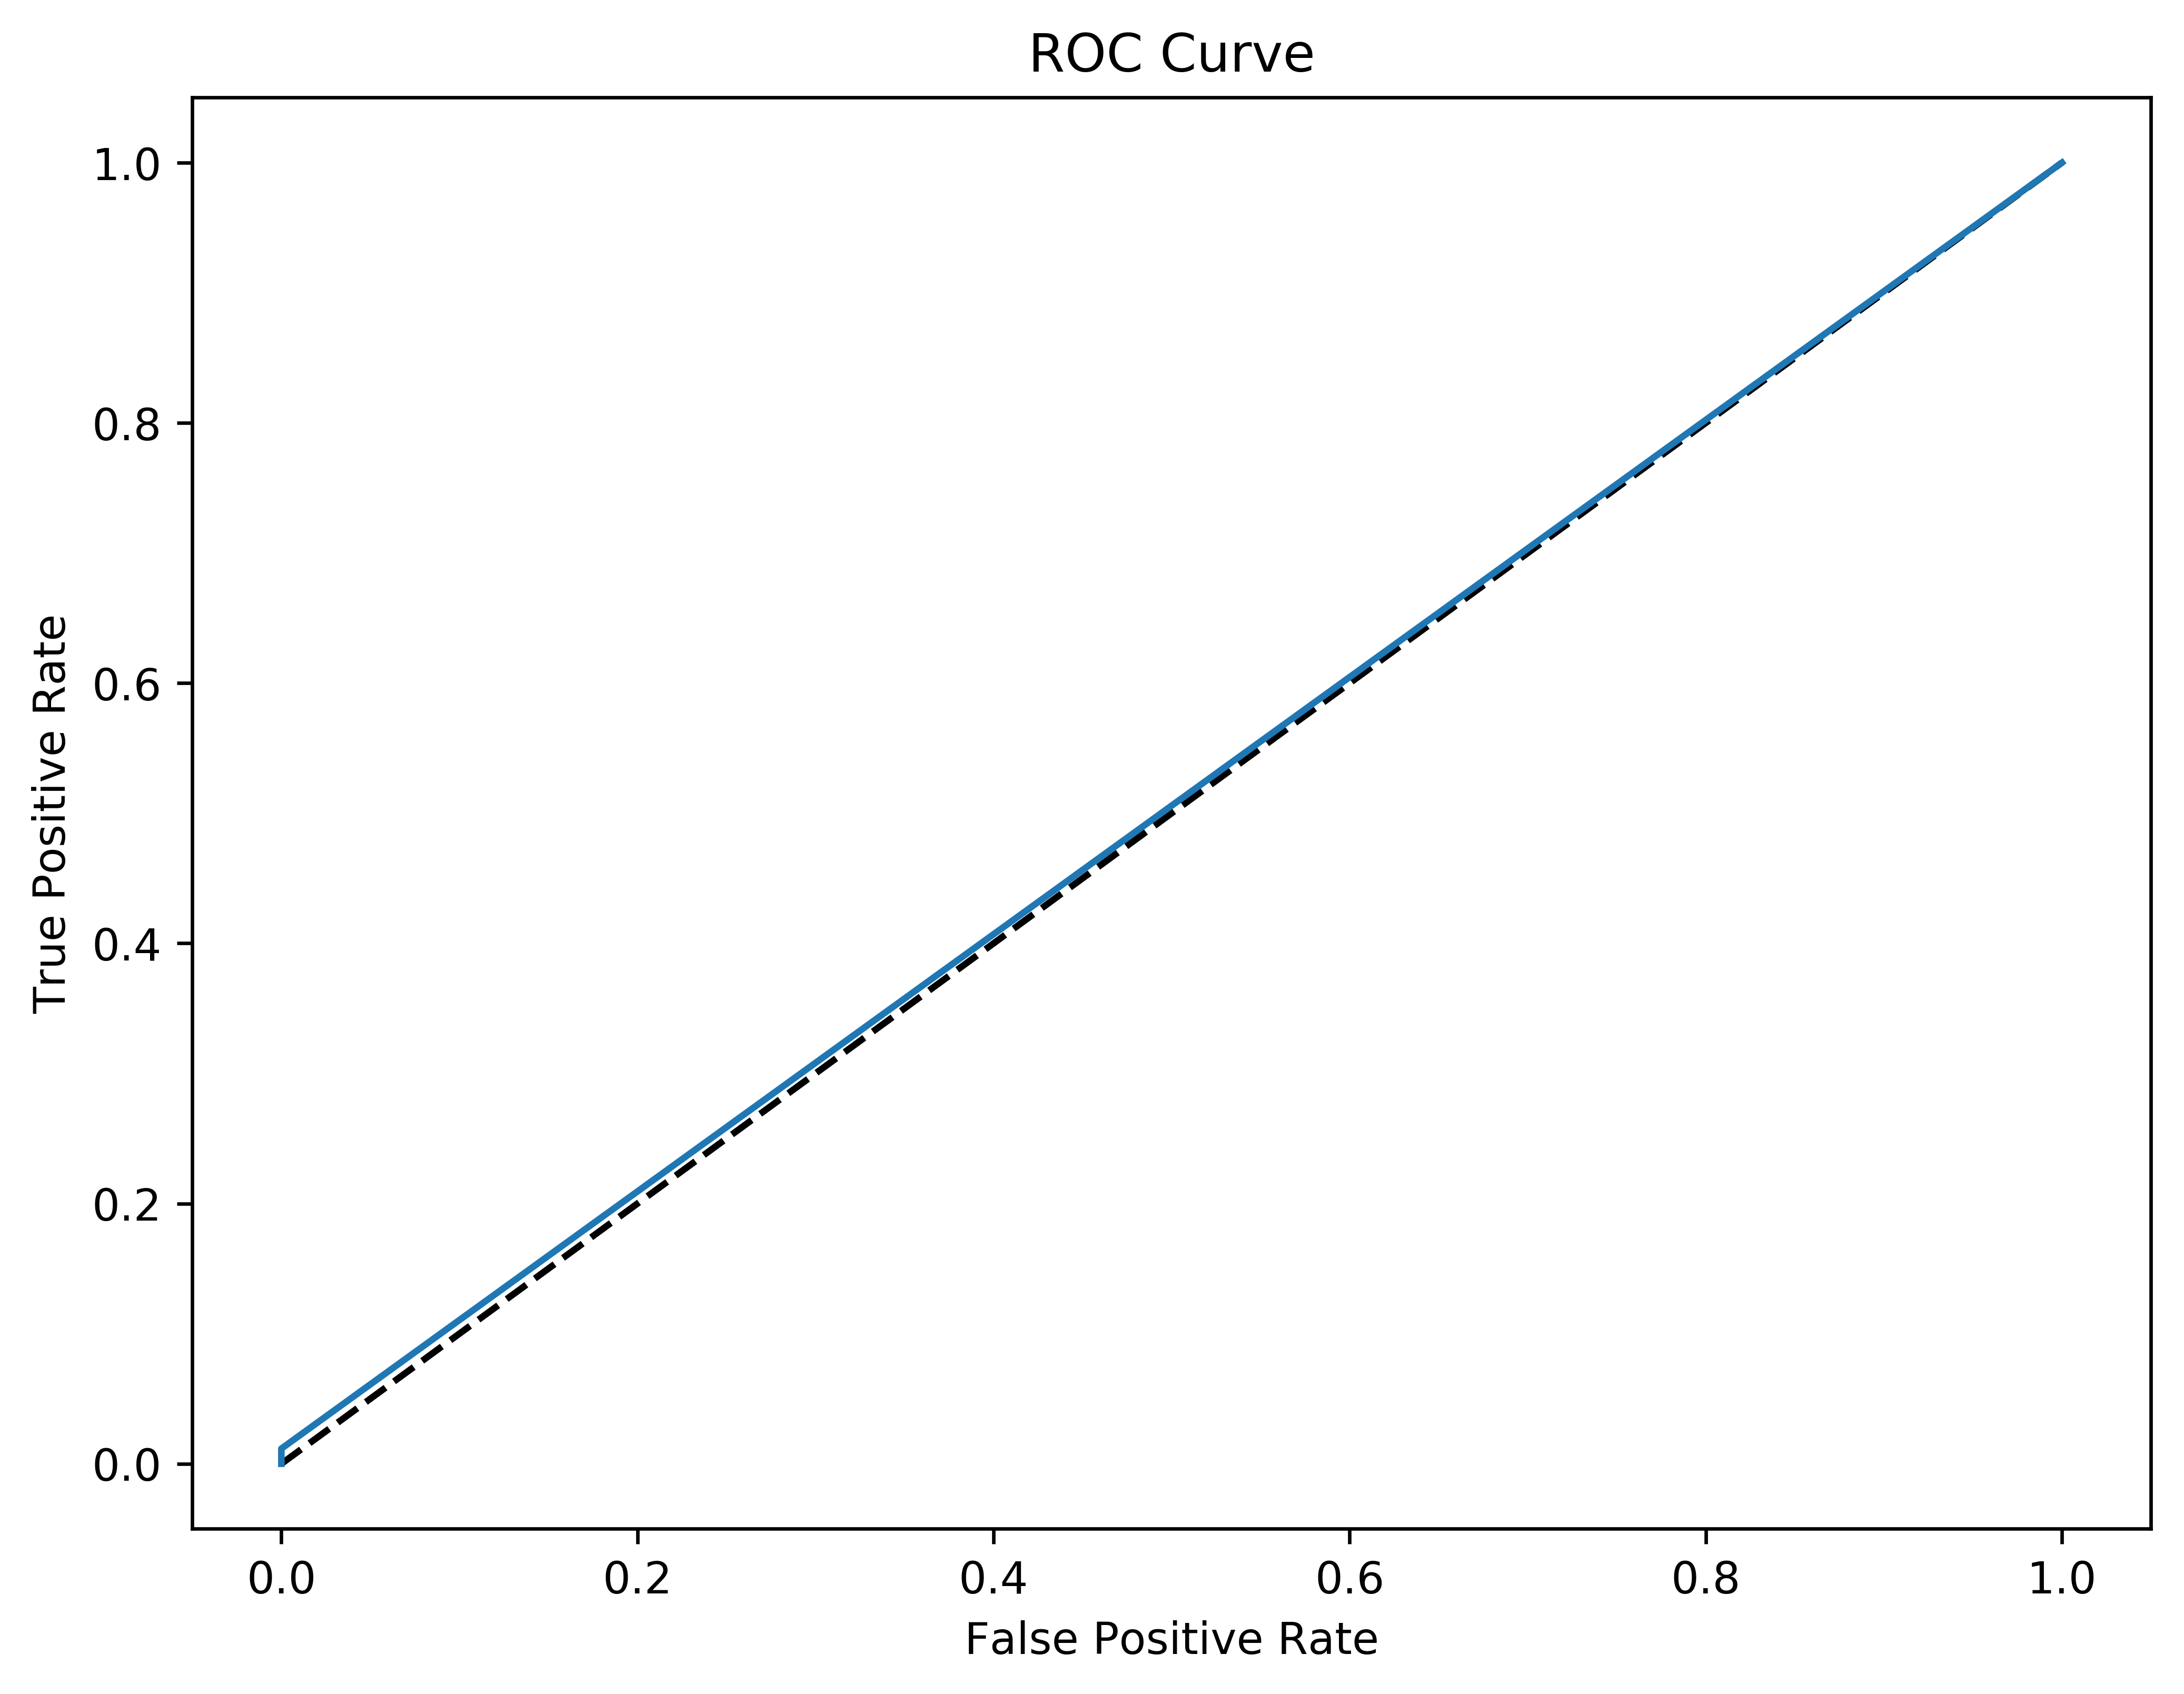

In [25]:
starttime = datetime.datetime.now()
mm225 = MN(44,22,5,1,activation='sigmoid')
mm225.train(X_std,y_train,0.001,iteration = 3000)
endtime = datetime.datetime.now()
print((endtime - starttime))
mm225.predict(test_x,test_y)

## Torch

In [33]:
# Hyper Parameters
EPOCH = 3000         # 
BATCH_SIZE = 80     # 80
LR = 0.001         # learning rate


import torch.utils.data as Data
tensor_data = torch.from_numpy(X_std)
tensor_data = tensor_data.float()
tensor_target = torch.from_numpy(y)

test_x = scaler.fit_transform(test_x)
test_x = torch.from_numpy(test_x)
test_x = test_x.float()


torch_dataset = Data.TensorDataset(tensor_data, tensor_target)
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 
)


net2 = torch.nn.Sequential(
    torch.nn.Linear(44, 3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 2),
)
loss_func = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net2.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer = torch.optim.SGD(net2.parameters(), lr=LR)

/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
starttime = datetime.datetime.now()
for epoch in range(EPOCH):   # 3000
    for i, (batch_x, batch_y) in enumerate(loader):
        output = net2(batch_x)               #  output
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    if epoch % 100 == 0:
        test_output = net2(test_x)                   # (samples, time_step, input_size)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
endtime = datetime.datetime.now()
print((endtime - starttime))

Epoch:  0 | train loss: 0.7056 | test accuracy: 15.00
Epoch:  100 | train loss: 0.7035 | test accuracy: 15.00
Epoch:  200 | train loss: 0.7017 | test accuracy: 15.00
Epoch:  300 | train loss: 0.7003 | test accuracy: 15.00
Epoch:  400 | train loss: 0.6991 | test accuracy: 15.00
Epoch:  500 | train loss: 0.6981 | test accuracy: 15.00
Epoch:  600 | train loss: 0.6972 | test accuracy: 15.00
Epoch:  700 | train loss: 0.6965 | test accuracy: 15.00
Epoch:  800 | train loss: 0.6960 | test accuracy: 15.00
Epoch:  900 | train loss: 0.6955 | test accuracy: 15.00
Epoch:  1000 | train loss: 0.6951 | test accuracy: 15.00
Epoch:  1100 | train loss: 0.6948 | test accuracy: 15.00
Epoch:  1200 | train loss: 0.6945 | test accuracy: 15.00
Epoch:  1300 | train loss: 0.6943 | test accuracy: 15.00
Epoch:  1400 | train loss: 0.6941 | test accuracy: 15.00
Epoch:  1500 | train loss: 0.6939 | test accuracy: 15.00
Epoch:  1600 | train loss: 0.6938 | test accuracy: 15.00
Epoch:  1700 | train loss: 0.6937 | test ac

Epoch:  0 | train loss: 0.7409 | test accuracy: 15.00
Epoch:  100 | train loss: 0.7318 | test accuracy: 15.00
Epoch:  200 | train loss: 0.7243 | test accuracy: 15.00
Epoch:  300 | train loss: 0.7182 | test accuracy: 15.00
Epoch:  400 | train loss: 0.7132 | test accuracy: 15.00
Epoch:  500 | train loss: 0.7091 | test accuracy: 15.00
Epoch:  600 | train loss: 0.7058 | test accuracy: 15.00
Epoch:  700 | train loss: 0.7031 | test accuracy: 15.00
Epoch:  800 | train loss: 0.7009 | test accuracy: 15.00
Epoch:  900 | train loss: 0.6991 | test accuracy: 15.00
Epoch:  1000 | train loss: 0.6976 | test accuracy: 15.00
Epoch:  1100 | train loss: 0.6964 | test accuracy: 15.00
Epoch:  1200 | train loss: 0.6955 | test accuracy: 15.00
Epoch:  1300 | train loss: 0.6947 | test accuracy: 15.00
Epoch:  1400 | train loss: 0.6940 | test accuracy: 15.00
Epoch:  1500 | train loss: 0.6935 | test accuracy: 15.00
Epoch:  1600 | train loss: 0.6931 | test accuracy: 15.00
Epoch:  1700 | train loss: 0.6927 | test ac

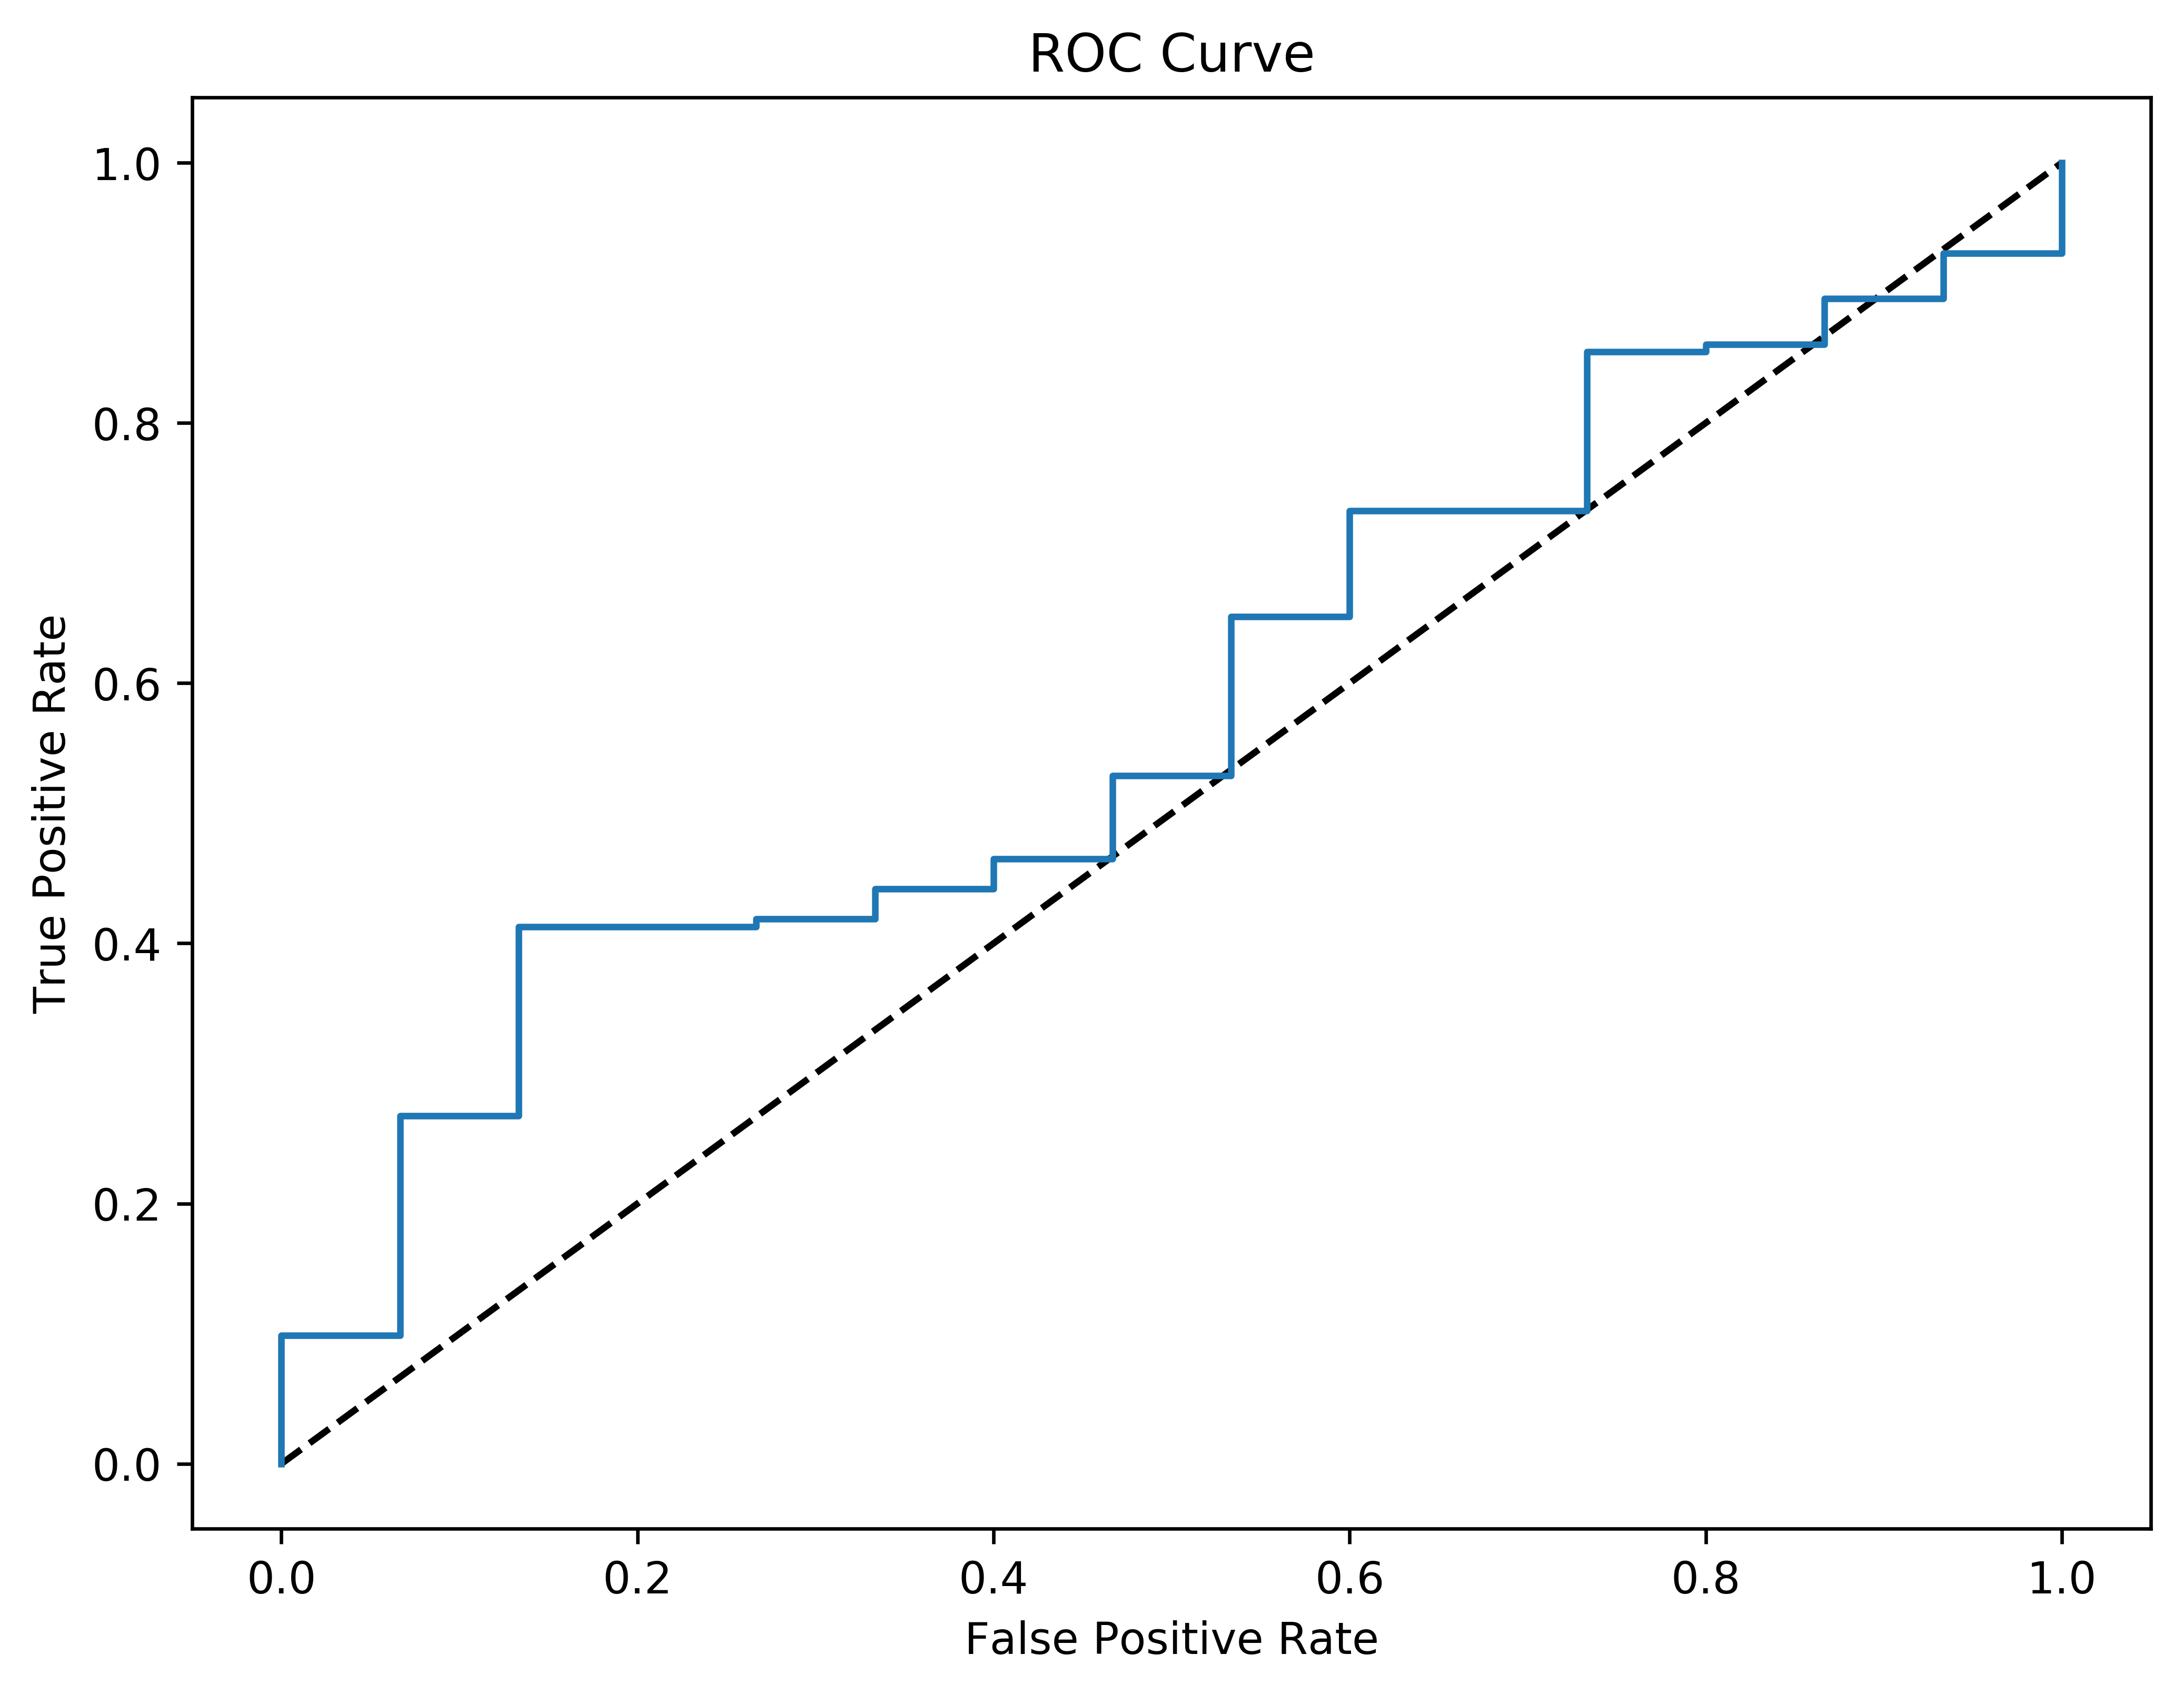

In [63]:
#Final fine tune numpy model - with dropout
EPOCH = 3000          # 
BATCH_SIZE = 80     # 20
LR = 0.001         # learning rate

net2 = torch.nn.Sequential(
    torch.nn.Linear(44, 3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(3, 4),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 2),
)
#optimizer = torch.optim.Adam(net2.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer = torch.optim.SGD(net2.parameters(), lr=LR)
starttime = datetime.datetime.now()
for epoch in range(EPOCH):   # 
    for i, (batch_x, batch_y) in enumerate(loader):
        output = net2(batch_x)               #  output
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    if epoch % 100 == 0:
        test_output = net2(test_x)                   # (samples, time_step, input_size)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
endtime = datetime.datetime.now()
print((endtime - starttime))

def softMax(X):
    result = [np.array([(np.exp(x[0])/(np.exp(x[0])+np.exp(x[1]))), (np.exp(x[1])/(np.exp(x[0])+np.exp(x[1])))]) for x in X ]
    return result

def getScore(X,y):
    test_output = net2(X)
    y_pro = [p[1] for p in softMax(test_output.data.numpy())]
    y_pred = [1 if c > 0.5 else 0 for c in y_pro]
    y_true = [i for i in y.reshape(1,-1)[0]]
    
    fpr,tpr,thresholds = roc_curve(y, y_pro)
    acc = list(np.array(y_true)-np.array(y_pred)).count(0)/len(y_pred)
        
    print('Acc: {}'.format(acc))
    print(classification_report(y_true,y_pred))
    print(confusion_matrix(y_true,y_pred))
    print("AUC: {}".format(roc_auc_score(y_true, y_pred)))
    sns.set_style()
    plt.figure(figsize=(8,6),dpi = 300)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


getScore(test_x,test_y)

In [64]:
all_list = []
for i in range(1,9):
    aver = []
    netdrop = torch.nn.Sequential(
        torch.nn.Linear(44,22 ),
        torch.nn.Dropout(0.1*i),
        torch.nn.Sigmoid(),
        torch.nn.Linear(22, 5),
        torch.nn.Dropout(0.1*i),
        torch.nn.Sigmoid(),
        torch.nn.Linear(5, 2))

    optimizer = torch.optim.Adam(netdrop.parameters(), lr=0.001,betas=(0.9, 0.99))
    starttime = datetime.datetime.now()
    for epoch in range(EPOCH):   # 训练所有!整套!数据 1500次
        for step, (batch_x, batch_y) in enumerate(loader):
            output = net2(batch_x)               #  output
            loss = loss_func(output, batch_y)   # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients
        if epoch % 200 == 0:
            test_output = net2(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            aver.append(loss.data.numpy())
    all_list.append(np.mean(aver))
        
    endtime = datetime.datetime.now()
    print((endtime - starttime))


Epoch:  0 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  200 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  400 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  600 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  800 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  1000 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  1200 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  1400 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  1600 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  1800 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  2000 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  2200 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  2400 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  2600 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  2800 | train loss: 0.6910 | test accuracy: 16.68
0:00:03.406269
Epoch:  0 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  200 | train loss: 0.6910 | test accuracy: 16.68
Epoch:  400 | train loss: 0

In [65]:
print('The best Dropout Rate is ',(all_list.index(min(all_list))+1)/10)

The best Dropout Rate is  0.6


## Optimizer

In [66]:
# Initial net for each optimizer
net_SGD = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)

net_Momentum = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)

net_RMSprop = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)

net_Adam = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)

nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

# different optimizers
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

loss_func = torch.nn.CrossEntropyLoss()
losses_his = [[], [], [], []]   # 

for epoch in range(EPOCH):
    #print('Epoch: ', epoch)
    for i, (batch_x, batch_y) in enumerate(loader):
        
        for net, opt, l_his in zip(nets, optimizers, losses_his):
            output = net(batch_x)              # get output for every net
            loss = loss_func(output, batch_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()
            
            if epoch % 50 == 0 :    # apply gradients
                l_his.append(loss.data.numpy())     # loss recoder



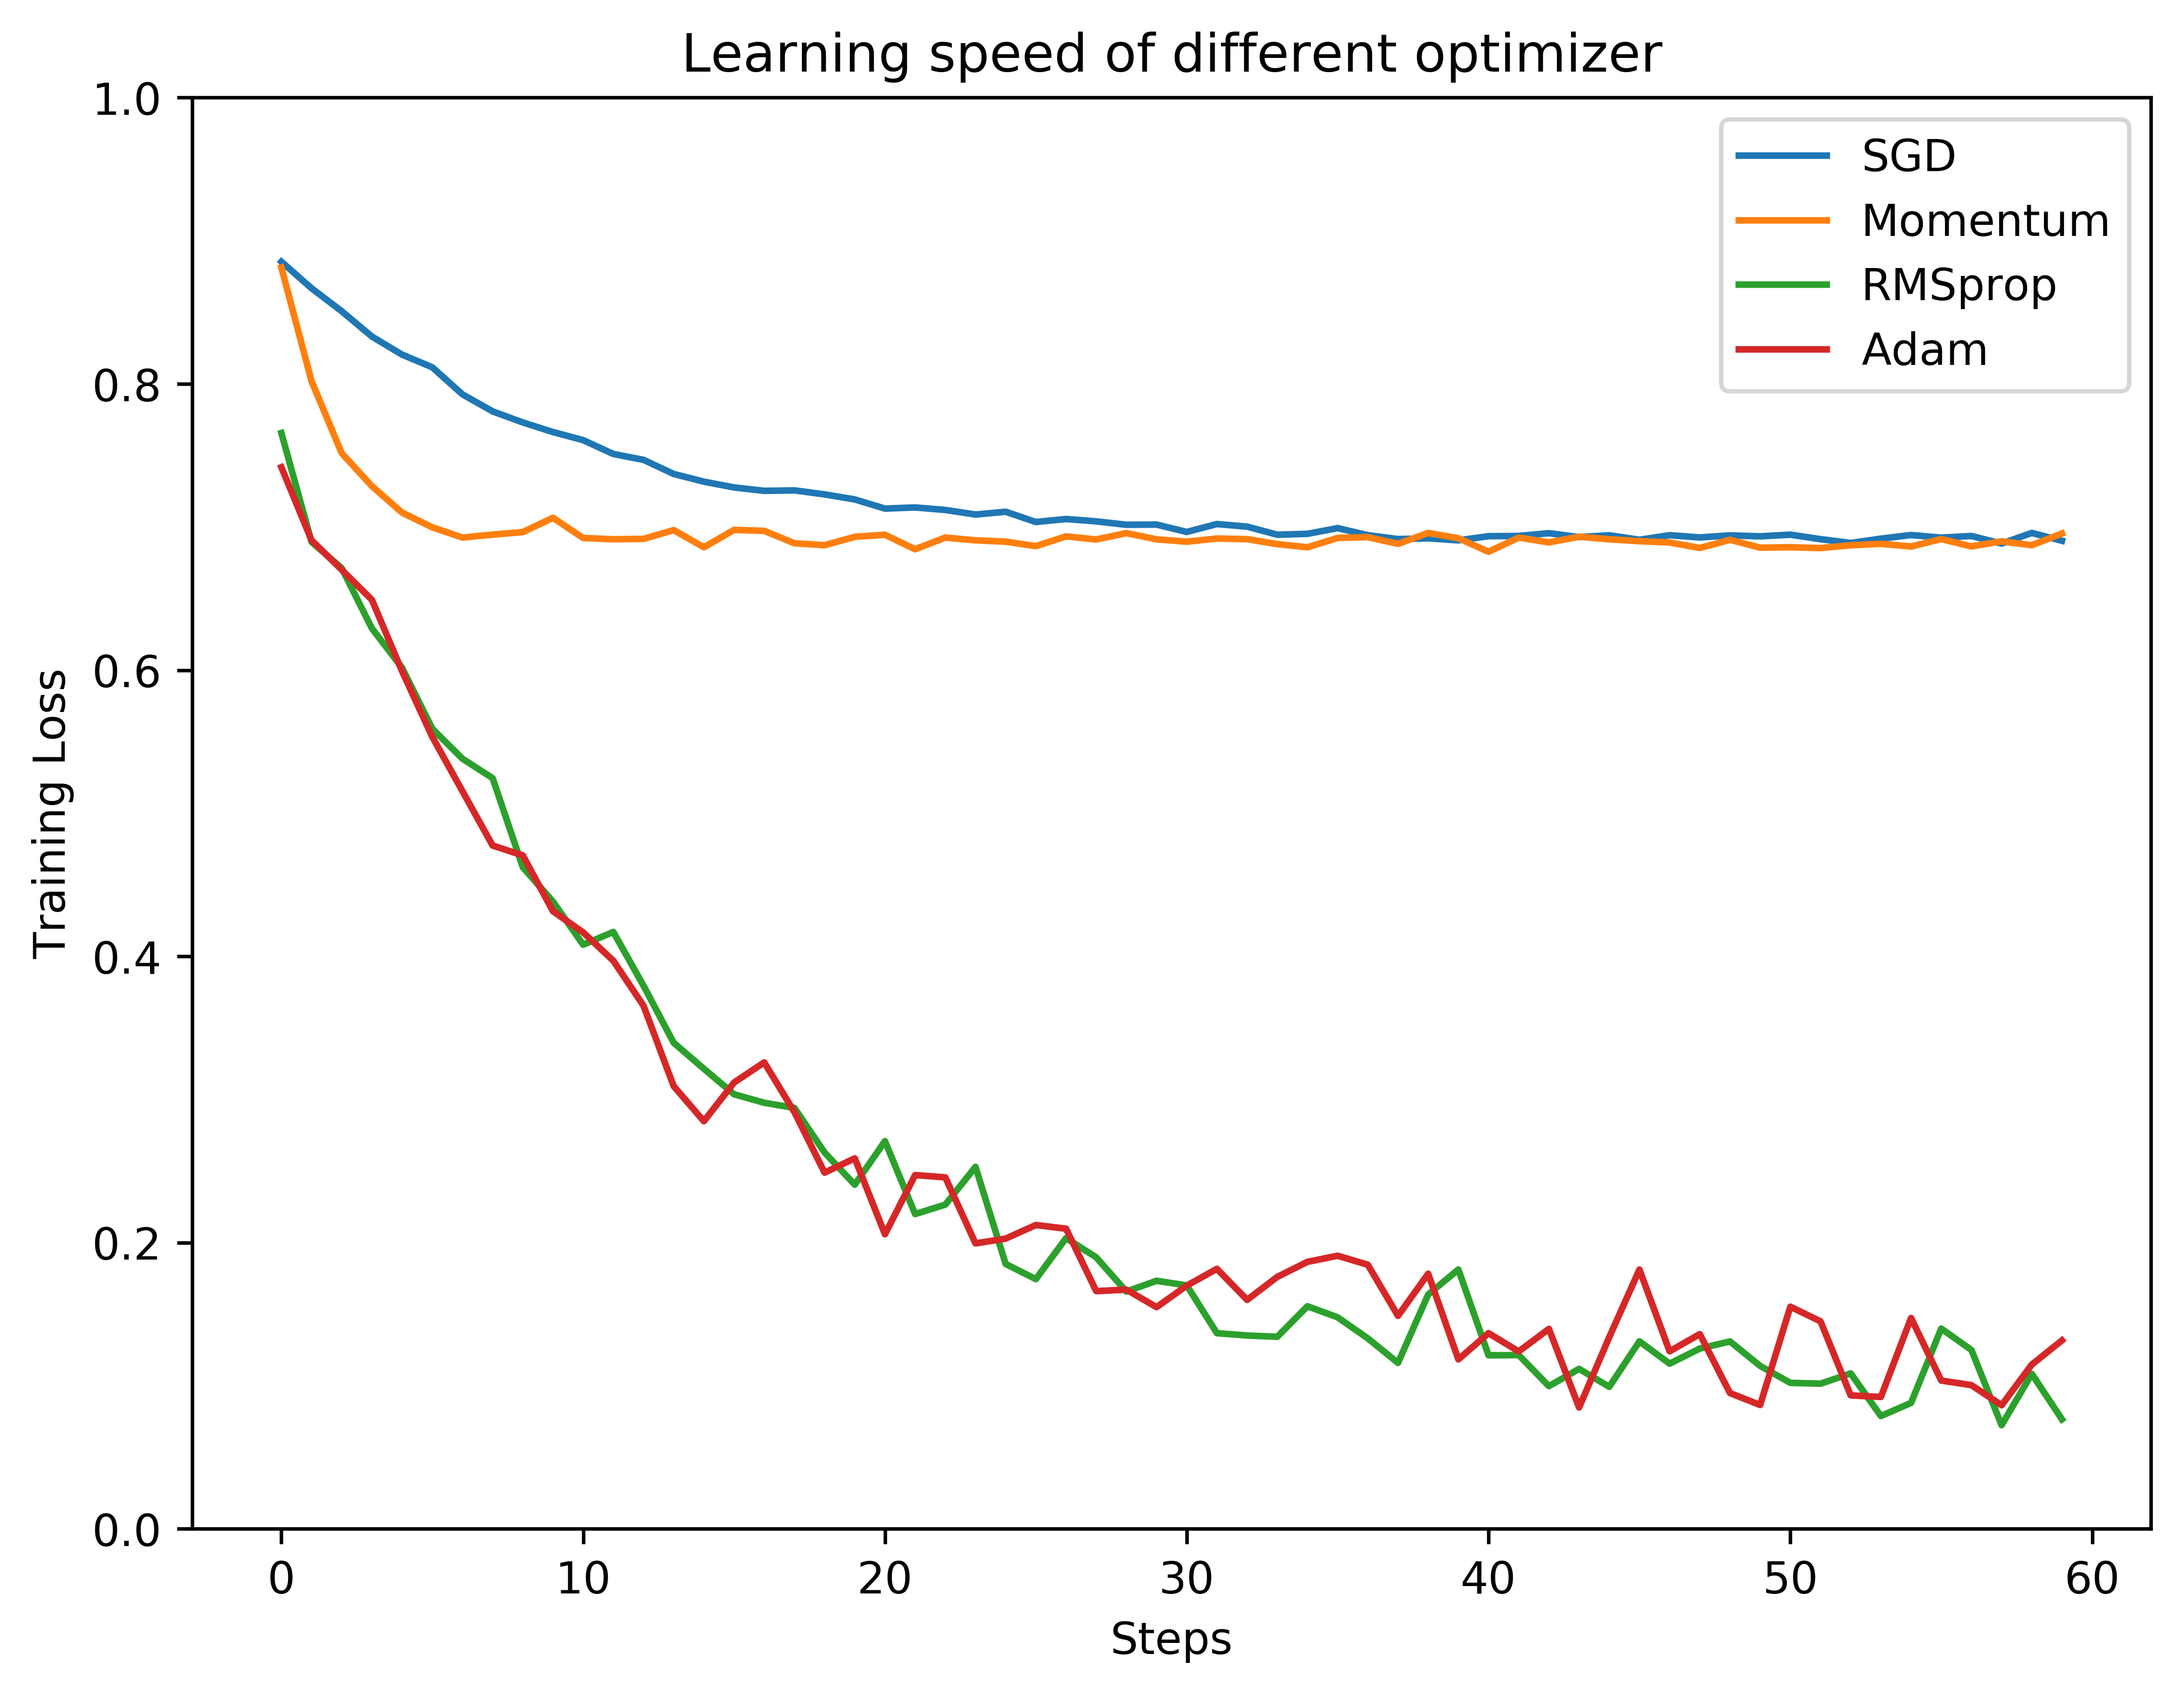

In [67]:
#Ploting graphes
sns.set_style()
plt.figure(figsize=(8,6),dpi = 300)
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(losses_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.ylim((0, 1))
plt.title('Learning speed of different optimizer')
plt.show()


Epoch:  0 | train loss: 0.6986 | test accuracy: 172.00
Epoch:  100 | train loss: 0.6616 | test accuracy: 85.52
Epoch:  200 | train loss: 0.6040 | test accuracy: 97.28
Epoch:  300 | train loss: 0.5278 | test accuracy: 97.28
Epoch:  400 | train loss: 0.4543 | test accuracy: 90.56
Epoch:  500 | train loss: 0.4128 | test accuracy: 89.72
Epoch:  600 | train loss: 0.3444 | test accuracy: 88.88
Epoch:  700 | train loss: 0.3279 | test accuracy: 89.72
Epoch:  800 | train loss: 0.2927 | test accuracy: 93.08
Epoch:  900 | train loss: 0.2134 | test accuracy: 93.08
Epoch:  1000 | train loss: 0.2425 | test accuracy: 95.60
Epoch:  1100 | train loss: 0.2445 | test accuracy: 93.08
Epoch:  1200 | train loss: 0.1648 | test accuracy: 93.08
Epoch:  1300 | train loss: 0.1913 | test accuracy: 94.76
Epoch:  1400 | train loss: 0.1347 | test accuracy: 89.72
Epoch:  1500 | train loss: 0.1453 | test accuracy: 91.40
Epoch:  1600 | train loss: 0.1724 | test accuracy: 95.60
Epoch:  1700 | train loss: 0.1738 | test a

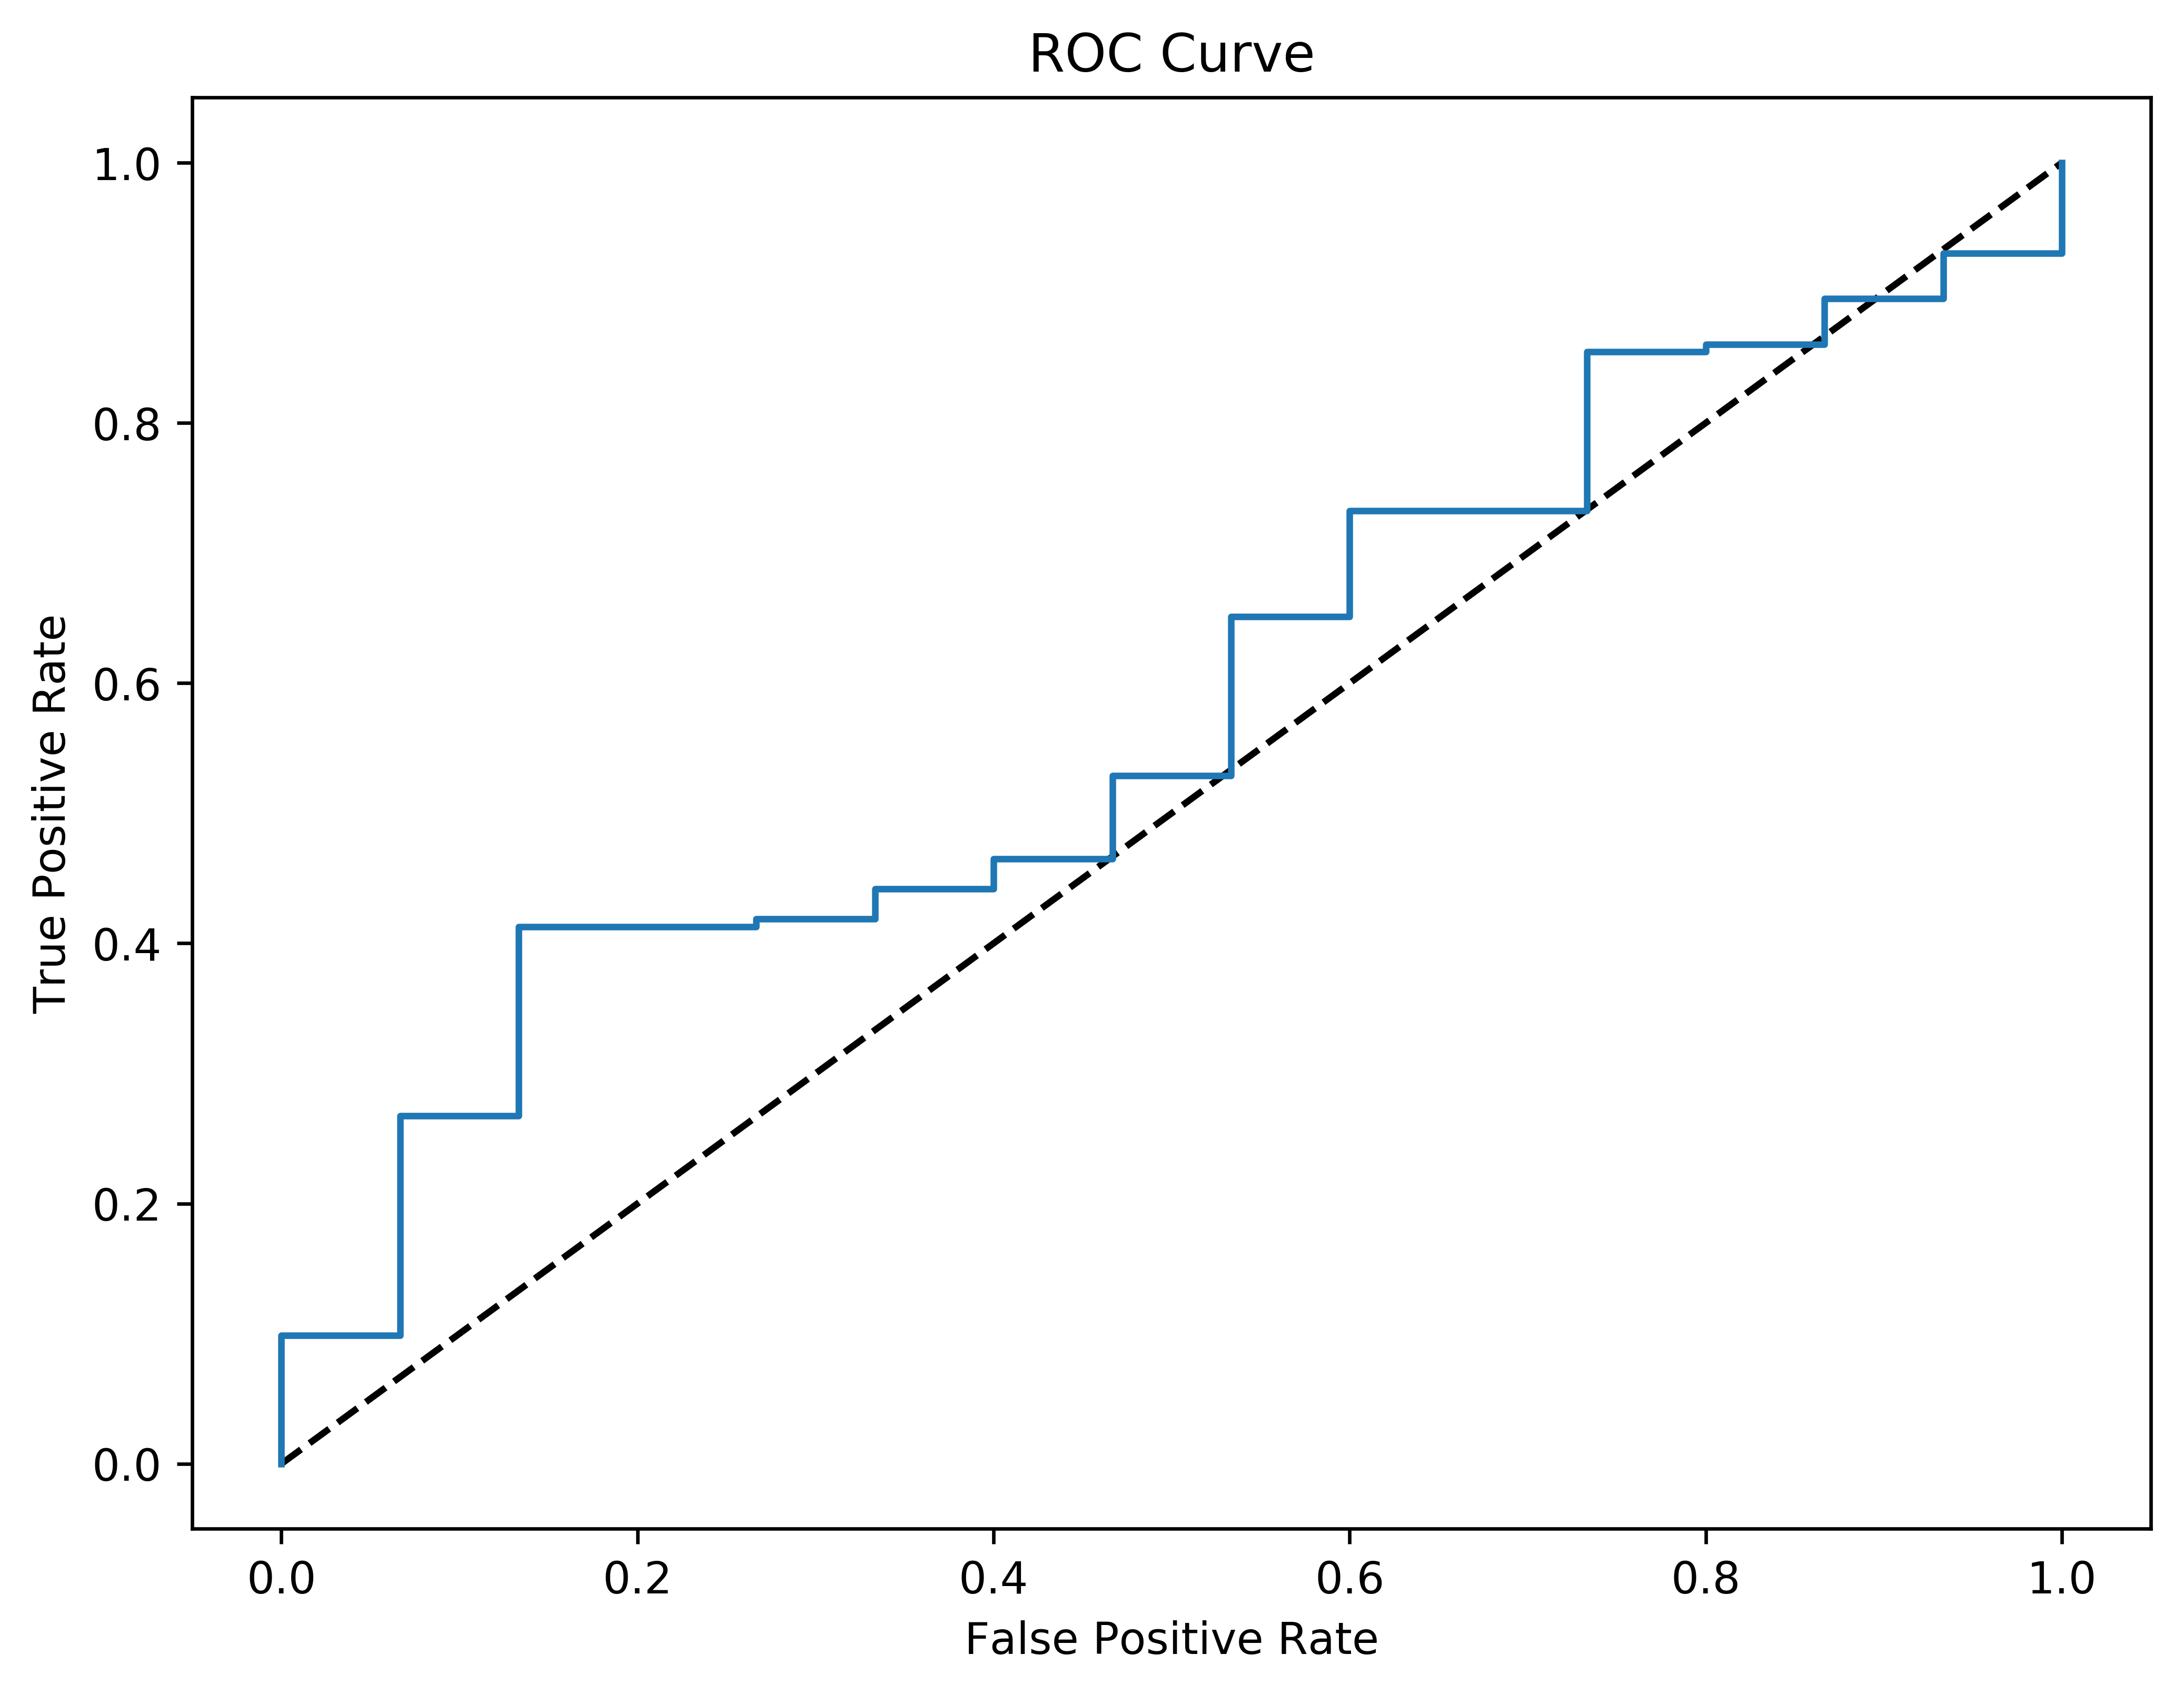

In [72]:
#Final fine tune numpy model - with dropout
EPOCH = 3000          # 
BATCH_SIZE = 80     # 20
LR = 0.001         # learning rate

netf = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.6),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)
optimizer = torch.optim.Adam(netf.parameters(), lr=LR, betas=(0.9, 0.99))
starttime = datetime.datetime.now()
for epoch in range(EPOCH):   # 
    for i, (batch_x, batch_y) in enumerate(loader):
        output = netf(batch_x)               #  output
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    if epoch % 100 == 0:
        test_output = netf(test_x)                   # (samples, time_step, input_size)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
endtime = datetime.datetime.now()
print((endtime - starttime))


getScore(test_x,test_y)
#0:00:05.804908
#Acc: 0.5401069518716578
#AUC: 0.7195736434108527